<a href="https://colab.research.google.com/github/Stanfording/small_GAN_testing/blob/main/64_cele_small_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Goal:   Just get a small GAN running



Get the preprocessed celebHD data from google drive

In [59]:
# #Download the dataset
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KqBRLsB0CJuQGycvaPINwaPgcGDUsAxN' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KqBRLsB0CJuQGycvaPINwaPgcGDUsAxN" -O "proCeleba.zip" && rm -rf /tmp/cookies.txt

# #unzip the dataset
# !unzip "/content/proCeleba.zip"

# #remove unnecessary files
# !rm -rf /content/__MACOSX

## Import libraries

### Install oneflow framework

In [60]:
#!python3 -m pip install -f https://release.oneflow.info oneflow==0.7.0+cu102

In [61]:
#import oneflow as t

In [62]:
from tqdm import tqdm

from torch.autograd import Variable, grad
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import os
import torch as t
import torch.nn as nn
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
from skimage import io


### Set initial hyperparameters

In [63]:

img_fold_dir_64_reso = "/content/proCeleba/16"

batch_size = 1024

resolution = 16

iteration = 200

critic = 5

eval_size = 25

laten_space = 100

score_dif = 0.1

device = t.device('cuda' if t.cuda.is_available() else 'cpu')

log_folder = "log"
!mkdir "log"
!mkdir "log/checkpoint"
!mkdir "log/sample"

mkdir: cannot create directory ‘log’: File exists
mkdir: cannot create directory ‘log/checkpoint’: File exists
mkdir: cannot create directory ‘log/sample’: File exists


### Show me which gpu I am using.

In [64]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a2b88e80-e62d-872a-a441-d18d16fcacdb)


### Pre loading the data

In [65]:
# Define a data class for load unclassfied data.
class Get_No_Classes_Img_Dataset(Dataset):
    
    def __init__(self, folder_dir, transform = None):
        self.folder_dir = os.path.join(folder_dir)
        self.transform = transform
        self.image_list = os.listdir(self.folder_dir)
        
    def __len__(self):
        return len(os.listdir(self.folder_dir))
    
    def __getitem__(self, index):
        
        image_name = self.image_list[index]
        
        image_dir = os.path.join(self.folder_dir, image_name)
        
        image = io.imread(image_dir)
        
        if (self.transform != None):
            image = self.transform(image)
        
        return image
    

transform = transforms.ToTensor() #From Batch * Highth * Width * Channel to Batch * Channel * Highth * Width
                                  #Which is what pytorch CNN can work with.

dataset = Get_No_Classes_Img_Dataset(img_fold_dir_64_reso, transform = transform) 
                                                            # datasets[0].shape = (16,16,3)
                                                            # len(datasets) = 28000
total_data_len = len(dataset)
                                                                                            
#datasets_batched = DataLoader(datasets, batch_size = batch_size) #loader is renewed every epoch




```
loader = iter(loader)
print(next(loader).shape) 
```
will output


```
torch.Size([batch_size, 3, resolution, resolution])
```

So data loading is ready.

What's left is keep using 

```
next(loader)
```
to access each batch of data


### Visualize a picture

In [66]:




from IPython.display import Image, display




# Viewing one data sample function:
def showOneImge(img, i, shouldSave):
    
    img = img.squeeze()
    
    img = transforms.ToPILImage()(img)
    
    plt.figure(figsize = (10,10), dpi = 10)
    plt.axis('off')
    
    if shouldSave:
      saveDir = f'{log_folder}/sample/{str(i).zfill(6)}.png'
      plt.imshow(img)
      plt.savefig(saveDir, bbox_inches='tight', pad_inches = 0)
      img = Image(saveDir)
      display(img)
    else:
      deleteDir = f"{log_folder}/sample/Delete.png"
      plt.imshow(img)
      plt.savefig(deleteDir, bbox_inches='tight', pad_inches = 0)
      img = Image(deleteDir)
      display(img)
      !rm "/content/log/sample/Delete.png"
    return 

''' Testing showOneImage'''
# loader = DataLoader(datasets, batch_size = batch_size)

# data = iter(loader)

# oneSample = next(data)[0]

# showOneImge(oneSample, 9999, True)


def showMoreImages(img, num):

  subplot_x = int(num ** (1/2))
  subplot_y = num // subplot_x
  plt.figure(figsize = (2,2))
  for i in range(len(img)):
      aimg = transforms.ToPILImage()(img[i])
      plt.subplot(subplot_x, subplot_y, i+1)
      plt.imshow(aimg)
      plt.axis('off')

-------------------------------------------------

### Now Designing the simple GAN network

In [67]:
"""
Define the generator
"""

class G(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.laten = nn.Sequential(
            nn.Linear(laten_space, 100),
            nn.Linear(100, 500),
            nn.Linear(500, 128 * resolution * resolution))

        self.model = nn.Sequential(
            nn.ConvTranspose2d(128, 64, (3, 3), padding = "same"),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, (3, 3), padding = "same"),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, (3, 3), padding = "same"),
            nn.Sigmoid()
        )
        
        
        
    def forward(self, theInput, batch_size):
        
        x = self.laten(theInput)
        
        x = t.reshape(x, (batch_size, 128, resolution, resolution))
         
        x = self.model(x)
            
            
        return x
    
class D(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.netWork = nn.Sequential(
            nn.Conv2d(3, 64, (3, 3), padding = "same"),
            nn.LeakyReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, (3, 3), stride = (3, 3)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 1, (3, 3), stride = (3, 3)),
            nn.Flatten())
        
    def forward(self, theInput):
        
        return self.netWork(theInput)

### Testing the network

In [68]:
"""

Testing the net work:

"""

# oneImg = next(iter(datasets))[0]

# showOneImge(oneImg, 0)

# oneImg = oneImg.expand(1,3,64,64)

# print(oneImg.shape)

# print(oneImg)

# #img into G to test shape

# input_noise_example = t.randn((batch_size, 1, 1, 5))

# a = G()(input_noise_example, batch_size)
# print(a[0])
# showOneImge(a[0], 0)

# b = D()(next(loader))

# print(b.shape)

'\n\nTesting the net work:\n\n'

### Gradient Penalty from wGAN, will test later.

In [69]:
def compute_gradient_penalty(D, real_samples, fake_samples, current_batch_size):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = t.randn((current_batch_size, 1, 1, 1)).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    
    d_interpolates = D(interpolates)
    
    
    grad_x_hat = grad(
            outputs=d_interpolates.sum(), inputs=interpolates, create_graph=True)[0]
    grad_penalty = ((grad_x_hat.view(grad_x_hat.size(0), -1)
                      .norm(2, dim=1) - 1)**2).mean()
    grad_penalty = 10 * grad_penalty
    
    return grad_penalty

### Initializing the generator, discriminator, optimizer, labels, and loss.

In [70]:
generator = G().to(device)
discriminator = D().to(device)


G_optimizer = t.optim.Adam(generator.parameters(), lr = 0.0001)
D_optimizer = t.optim.Adam(discriminator.parameters(), lr = 0.0001)

label_real = t.ones((batch_size, 1)).to(device)
label_fake = t.zeros((batch_size, 1)).to(device)

bceLoss = nn.BCEWithLogitsLoss()

should_train_G = True #True = train d, False = train g

### Train decider

In [71]:
def what_to_train(fake_score, real_score, should_train_G):
  last_should_train_G = should_train_G


  if (fake_score < real_score * score_dif):
    return True

  if last_should_train_G:
    if (fake_score > real_score * (1 - score_dif)):
      return False
    else:
      return True

  return False


  
  



### Start training

Epoch: 1: 100%|██████████| 28/28 [00:15<00:00,  1.77it/s, D_total_loss=-.827, G_loss=0.185, fake_score=-.143, real_score=0.771]


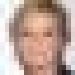

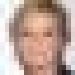

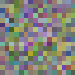

epoch =  1
Epoch [0/200], Step [28/28], d_loss: -0.8272, g_loss: 0.1847, D(x): 0.77, D(G(z)): -0.14


Epoch: 3: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-2.28, G_loss=2.25, fake_score=-2.17, real_score=0.288]


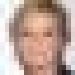

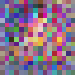

epoch =  3
Epoch [2/200], Step [28/28], d_loss: -2.2825, g_loss: 2.2545, D(x): 0.29, D(G(z)): -2.17


Epoch: 5: 100%|██████████| 28/28 [00:16<00:00,  1.74it/s, D_total_loss=-3.55, G_loss=5.27, fake_score=-5.18, real_score=-1.28]


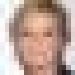

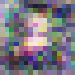

epoch =  5
Epoch [4/200], Step [28/28], d_loss: -3.5487, g_loss: 5.2702, D(x): -1.28, D(G(z)): -5.18


Epoch: 7: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s, D_total_loss=-3.72, G_loss=5.74, fake_score=-5.53, real_score=-1.4]


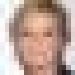

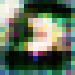

epoch =  7
Epoch [6/200], Step [28/28], d_loss: -3.7210, g_loss: 5.7438, D(x): -1.40, D(G(z)): -5.53


Epoch: 9: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-3.09, G_loss=4.37, fake_score=-4.28, real_score=-.75]


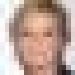

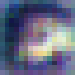

epoch =  9
Epoch [8/200], Step [28/28], d_loss: -3.0893, g_loss: 4.3695, D(x): -0.75, D(G(z)): -4.28


Epoch: 11: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-4.58, G_loss=3.94, fake_score=-3.75, real_score=1]


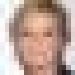

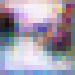

epoch =  11
Epoch [10/200], Step [28/28], d_loss: -4.5815, g_loss: 3.9405, D(x): 1.00, D(G(z)): -3.75


Epoch: 13: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s, D_total_loss=-5.67, G_loss=2.97, fake_score=-2.69, real_score=3.21]


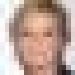

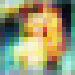

epoch =  13
Epoch [12/200], Step [28/28], d_loss: -5.6708, g_loss: 2.9719, D(x): 3.21, D(G(z)): -2.69


Epoch: 15: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s, D_total_loss=-6.79, G_loss=3.09, fake_score=-2.86, real_score=4.17]


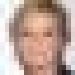

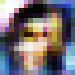

epoch =  15
Epoch [14/200], Step [28/28], d_loss: -6.7939, g_loss: 3.0859, D(x): 4.17, D(G(z)): -2.86


Epoch: 17: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-6.58, G_loss=2.02, fake_score=-1.84, real_score=5.08]


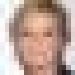

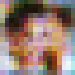

epoch =  17
Epoch [16/200], Step [28/28], d_loss: -6.5823, g_loss: 2.0237, D(x): 5.08, D(G(z)): -1.84


Epoch: 19: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-5.93, G_loss=-.738, fake_score=1.04, real_score=7.77]


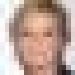

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


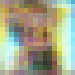

epoch =  19
Epoch [18/200], Step [28/28], d_loss: -5.9293, g_loss: -0.7375, D(x): 7.77, D(G(z)): 1.04


Epoch: 21: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s, D_total_loss=-6.7, G_loss=0.0038, fake_score=0.428, real_score=7.4]


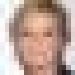

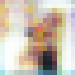

epoch =  21
Epoch [20/200], Step [28/28], d_loss: -6.6964, g_loss: 0.0038, D(x): 7.40, D(G(z)): 0.43


Epoch: 23: 100%|██████████| 28/28 [00:15<00:00,  1.78it/s, D_total_loss=-7.42, G_loss=0.785, fake_score=-.622, real_score=7.31]


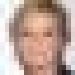

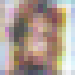

epoch =  23
Epoch [22/200], Step [28/28], d_loss: -7.4185, g_loss: 0.7850, D(x): 7.31, D(G(z)): -0.62


Epoch: 25: 100%|██████████| 28/28 [00:15<00:00,  1.79it/s, D_total_loss=-6.09, G_loss=0.567, fake_score=0.328, real_score=7.08]


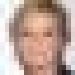

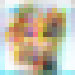

epoch =  25
Epoch [24/200], Step [28/28], d_loss: -6.0900, g_loss: 0.5669, D(x): 7.08, D(G(z)): 0.33


Epoch: 27: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-7.8, G_loss=1.22, fake_score=-.777, real_score=7.38]


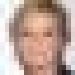

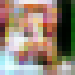

epoch =  27
Epoch [26/200], Step [28/28], d_loss: -7.7971, g_loss: 1.2247, D(x): 7.38, D(G(z)): -0.78


Epoch: 29: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s, D_total_loss=-6.42, G_loss=0.563, fake_score=-.0638, real_score=7.84]


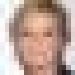

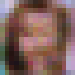

epoch =  29
Epoch [28/200], Step [28/28], d_loss: -6.4170, g_loss: 0.5631, D(x): 7.84, D(G(z)): -0.06


Epoch: 31: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s, D_total_loss=-6.31, G_loss=-.141, fake_score=0.458, real_score=7.29]


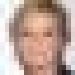

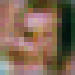

epoch =  31
Epoch [30/200], Step [28/28], d_loss: -6.3119, g_loss: -0.1405, D(x): 7.29, D(G(z)): 0.46


Epoch: 33: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s, D_total_loss=-6.51, G_loss=-.266, fake_score=0.586, real_score=7.36]


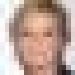

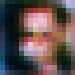

epoch =  33
Epoch [32/200], Step [28/28], d_loss: -6.5086, g_loss: -0.2661, D(x): 7.36, D(G(z)): 0.59


Epoch: 35: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-6.41, G_loss=-.664, fake_score=1.02, real_score=7.83]


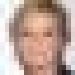

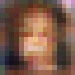

epoch =  35
Epoch [34/200], Step [28/28], d_loss: -6.4113, g_loss: -0.6642, D(x): 7.83, D(G(z)): 1.02


Epoch: 37: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-7.26, G_loss=-.102, fake_score=0.283, real_score=8.01]


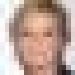

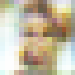

epoch =  37
Epoch [36/200], Step [28/28], d_loss: -7.2590, g_loss: -0.1022, D(x): 8.01, D(G(z)): 0.28


Epoch: 39: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-7, G_loss=0.148, fake_score=0.661, real_score=8.27]


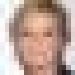

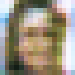

epoch =  39
Epoch [38/200], Step [28/28], d_loss: -7.0021, g_loss: 0.1483, D(x): 8.27, D(G(z)): 0.66


Epoch: 41: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-5.85, G_loss=0.363, fake_score=0.282, real_score=6.69]


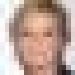

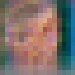

epoch =  41
Epoch [40/200], Step [28/28], d_loss: -5.8487, g_loss: 0.3629, D(x): 6.69, D(G(z)): 0.28


Epoch: 43: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-5.17, G_loss=-1.41, fake_score=1.72, real_score=7.59]


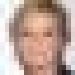

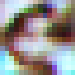

epoch =  43
Epoch [42/200], Step [28/28], d_loss: -5.1730, g_loss: -1.4112, D(x): 7.59, D(G(z)): 1.72


Epoch: 45: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s, D_total_loss=-7.72, G_loss=0.0383, fake_score=0.467, real_score=8.61]


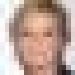

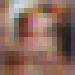

epoch =  45
Epoch [44/200], Step [28/28], d_loss: -7.7202, g_loss: 0.0383, D(x): 8.61, D(G(z)): 0.47


Epoch: 47: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s, D_total_loss=-6.62, G_loss=-.856, fake_score=0.968, real_score=8.16]


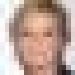

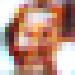

epoch =  47
Epoch [46/200], Step [28/28], d_loss: -6.6162, g_loss: -0.8556, D(x): 8.16, D(G(z)): 0.97


Epoch: 49: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-6.04, G_loss=-1.38, fake_score=1.69, real_score=8.24]


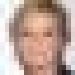

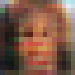

epoch =  49
Epoch [48/200], Step [28/28], d_loss: -6.0435, g_loss: -1.3800, D(x): 8.24, D(G(z)): 1.69


Epoch: 51: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-5.83, G_loss=-.9, fake_score=1.02, real_score=7.31]


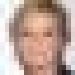

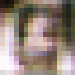

epoch =  51
Epoch [50/200], Step [28/28], d_loss: -5.8295, g_loss: -0.9005, D(x): 7.31, D(G(z)): 1.02


Epoch: 53: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-5.88, G_loss=-.0303, fake_score=0.165, real_score=6.53]


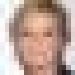

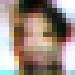

epoch =  53
Epoch [52/200], Step [28/28], d_loss: -5.8769, g_loss: -0.0303, D(x): 6.53, D(G(z)): 0.16


Epoch: 55: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-6.6, G_loss=-1.27, fake_score=0.984, real_score=8.36]


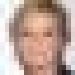

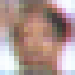

epoch =  55
Epoch [54/200], Step [28/28], d_loss: -6.5964, g_loss: -1.2729, D(x): 8.36, D(G(z)): 0.98


Epoch: 57: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-5.26, G_loss=-1.09, fake_score=2, real_score=7.77]


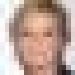

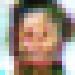

epoch =  57
Epoch [56/200], Step [28/28], d_loss: -5.2582, g_loss: -1.0866, D(x): 7.77, D(G(z)): 2.00


Epoch: 59: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-5.14, G_loss=-.128, fake_score=-.0406, real_score=7.79]


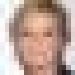

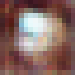

epoch =  59
Epoch [58/200], Step [28/28], d_loss: -5.1389, g_loss: -0.1280, D(x): 7.79, D(G(z)): -0.04


Epoch: 61: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s, D_total_loss=-8.7, G_loss=-.049, fake_score=0.0311, real_score=9.7]


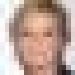

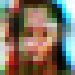

epoch =  61
Epoch [60/200], Step [28/28], d_loss: -8.7031, g_loss: -0.0490, D(x): 9.70, D(G(z)): 0.03


Epoch: 63: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-6.37, G_loss=-3.66, fake_score=3.66, real_score=10.7]


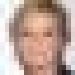

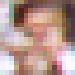

epoch =  63
Epoch [62/200], Step [28/28], d_loss: -6.3709, g_loss: -3.6580, D(x): 10.72, D(G(z)): 3.66


Epoch: 65: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s, D_total_loss=-3.95, G_loss=-4.78, fake_score=4.92, real_score=9.75]


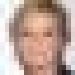

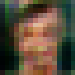

epoch =  65
Epoch [64/200], Step [28/28], d_loss: -3.9486, g_loss: -4.7798, D(x): 9.75, D(G(z)): 4.92


Epoch: 67: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-4.91, G_loss=-1.08, fake_score=1.45, real_score=6.71]


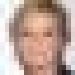

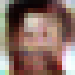

epoch =  67
Epoch [66/200], Step [28/28], d_loss: -4.9145, g_loss: -1.0813, D(x): 6.71, D(G(z)): 1.45


Epoch: 69: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-8.47, G_loss=3.31, fake_score=-3.2, real_score=5.93]


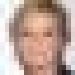

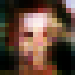

epoch =  69
Epoch [68/200], Step [28/28], d_loss: -8.4739, g_loss: 3.3100, D(x): 5.93, D(G(z)): -3.20


Epoch: 71: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s, D_total_loss=-5.48, G_loss=1.14, fake_score=-.943, real_score=4.89]


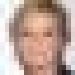

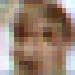

epoch =  71
Epoch [70/200], Step [28/28], d_loss: -5.4828, g_loss: 1.1392, D(x): 4.89, D(G(z)): -0.94


Epoch: 73: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-5.23, G_loss=0.734, fake_score=-.618, real_score=6.8]


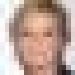

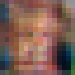

epoch =  73
Epoch [72/200], Step [28/28], d_loss: -5.2337, g_loss: 0.7336, D(x): 6.80, D(G(z)): -0.62


Epoch: 75: 100%|██████████| 28/28 [00:15<00:00,  1.79it/s, D_total_loss=-6.29, G_loss=-1.56, fake_score=1.88, real_score=8.56]


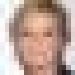

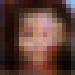

epoch =  75
Epoch [74/200], Step [28/28], d_loss: -6.2924, g_loss: -1.5574, D(x): 8.56, D(G(z)): 1.88


Epoch: 77: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.03, G_loss=-2.36, fake_score=2.16, real_score=9.69]


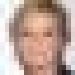

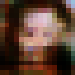

epoch =  77
Epoch [76/200], Step [28/28], d_loss: -7.0262, g_loss: -2.3600, D(x): 9.69, D(G(z)): 2.16


Epoch: 79: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-4.82, G_loss=-1.23, fake_score=1.91, real_score=7.5]


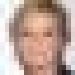

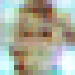

epoch =  79
Epoch [78/200], Step [28/28], d_loss: -4.8244, g_loss: -1.2327, D(x): 7.50, D(G(z)): 1.91


Epoch: 81: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.37, G_loss=-1.01, fake_score=1.01, real_score=8.68]


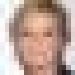

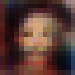

epoch =  81
Epoch [80/200], Step [28/28], d_loss: -7.3731, g_loss: -1.0068, D(x): 8.68, D(G(z)): 1.01


Epoch: 83: 100%|██████████| 28/28 [00:15<00:00,  1.84it/s, D_total_loss=-5.73, G_loss=-2.58, fake_score=2.91, real_score=9.37]


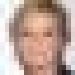

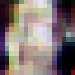

epoch =  83
Epoch [82/200], Step [28/28], d_loss: -5.7306, g_loss: -2.5832, D(x): 9.37, D(G(z)): 2.91


Epoch: 85: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-6.2, G_loss=-2.78, fake_score=3.32, real_score=10]


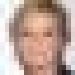

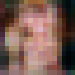

epoch =  85
Epoch [84/200], Step [28/28], d_loss: -6.1952, g_loss: -2.7780, D(x): 10.05, D(G(z)): 3.32


Epoch: 87: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-4.84, G_loss=-2.87, fake_score=3.39, real_score=8.95]


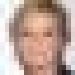

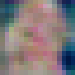

epoch =  87
Epoch [86/200], Step [28/28], d_loss: -4.8443, g_loss: -2.8742, D(x): 8.95, D(G(z)): 3.39


Epoch: 89: 100%|██████████| 28/28 [00:15<00:00,  1.84it/s, D_total_loss=-5.48, G_loss=-.667, fake_score=1.63, real_score=8.34]


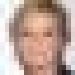

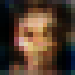

epoch =  89
Epoch [88/200], Step [28/28], d_loss: -5.4774, g_loss: -0.6675, D(x): 8.34, D(G(z)): 1.63


Epoch: 91: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-6.35, G_loss=-.845, fake_score=1.05, real_score=7.69]


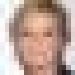

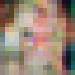

epoch =  91
Epoch [90/200], Step [28/28], d_loss: -6.3532, g_loss: -0.8448, D(x): 7.69, D(G(z)): 1.05


Epoch: 93: 100%|██████████| 28/28 [00:15<00:00,  1.84it/s, D_total_loss=-6.82, G_loss=-1.01, fake_score=1.46, real_score=8.51]


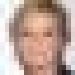

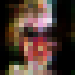

epoch =  93
Epoch [92/200], Step [28/28], d_loss: -6.8226, g_loss: -1.0129, D(x): 8.51, D(G(z)): 1.46


Epoch: 95: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-5.25, G_loss=-2.79, fake_score=3.09, real_score=8.91]


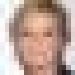

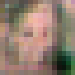

epoch =  95
Epoch [94/200], Step [28/28], d_loss: -5.2485, g_loss: -2.7931, D(x): 8.91, D(G(z)): 3.09


Epoch: 97: 100%|██████████| 28/28 [00:15<00:00,  1.84it/s, D_total_loss=-4.83, G_loss=-1.66, fake_score=1.63, real_score=9.04]


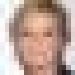

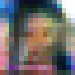

epoch =  97
Epoch [96/200], Step [28/28], d_loss: -4.8318, g_loss: -1.6574, D(x): 9.04, D(G(z)): 1.63


Epoch: 99: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-6.41, G_loss=-2.68, fake_score=2.5, real_score=9.42]


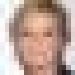

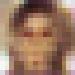

epoch =  99
Epoch [98/200], Step [28/28], d_loss: -6.4083, g_loss: -2.6817, D(x): 9.42, D(G(z)): 2.50


Epoch: 101: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-6.7, G_loss=-2.33, fake_score=2.5, real_score=9.48]


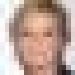

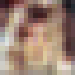

epoch =  101
Epoch [100/200], Step [28/28], d_loss: -6.6952, g_loss: -2.3277, D(x): 9.48, D(G(z)): 2.50


Epoch: 103: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-6.19, G_loss=-2.94, fake_score=3.12, real_score=9.51]


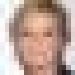

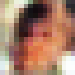

epoch =  103
Epoch [102/200], Step [28/28], d_loss: -6.1947, g_loss: -2.9356, D(x): 9.51, D(G(z)): 3.12


Epoch: 105: 100%|██████████| 28/28 [00:15<00:00,  1.84it/s, D_total_loss=-5.8, G_loss=-2.24, fake_score=2.44, real_score=9.69]


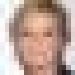

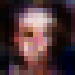

epoch =  105
Epoch [104/200], Step [28/28], d_loss: -5.7961, g_loss: -2.2448, D(x): 9.69, D(G(z)): 2.44


Epoch: 107: 100%|██████████| 28/28 [00:15<00:00,  1.85it/s, D_total_loss=-6.43, G_loss=-1.75, fake_score=2.17, real_score=8.82]


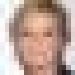

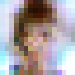

epoch =  107
Epoch [106/200], Step [28/28], d_loss: -6.4297, g_loss: -1.7537, D(x): 8.82, D(G(z)): 2.17


Epoch: 109: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-6.05, G_loss=-3.4, fake_score=3.78, real_score=10.1]


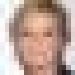

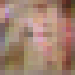

epoch =  109
Epoch [108/200], Step [28/28], d_loss: -6.0545, g_loss: -3.3978, D(x): 10.06, D(G(z)): 3.78


Epoch: 111: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-4.97, G_loss=-4.38, fake_score=4.57, real_score=11.4]


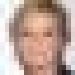

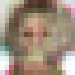

epoch =  111
Epoch [110/200], Step [28/28], d_loss: -4.9656, g_loss: -4.3849, D(x): 11.42, D(G(z)): 4.57


Epoch: 113: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-6.11, G_loss=-5.21, fake_score=5.62, real_score=12.2]


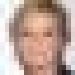

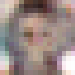

epoch =  113
Epoch [112/200], Step [28/28], d_loss: -6.1072, g_loss: -5.2106, D(x): 12.19, D(G(z)): 5.62


Epoch: 115: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-6.74, G_loss=-2.92, fake_score=3.03, real_score=10]


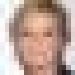

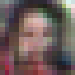

epoch =  115
Epoch [114/200], Step [28/28], d_loss: -6.7447, g_loss: -2.9199, D(x): 10.03, D(G(z)): 3.03


Epoch: 117: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.26, G_loss=-.565, fake_score=0.79, real_score=8.34]


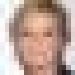

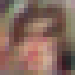

epoch =  117
Epoch [116/200], Step [28/28], d_loss: -7.2575, g_loss: -0.5651, D(x): 8.34, D(G(z)): 0.79


Epoch: 119: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-6.1, G_loss=-2.81, fake_score=2.22, real_score=9.19]


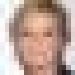

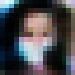

epoch =  119
Epoch [118/200], Step [28/28], d_loss: -6.0996, g_loss: -2.8135, D(x): 9.19, D(G(z)): 2.22


Epoch: 121: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-8.97, G_loss=-5.74, fake_score=5.42, real_score=15.3]


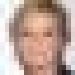

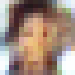

epoch =  121
Epoch [120/200], Step [28/28], d_loss: -8.9695, g_loss: -5.7419, D(x): 15.27, D(G(z)): 5.42


Epoch: 123: 100%|██████████| 28/28 [00:15<00:00,  1.84it/s, D_total_loss=-5.91, G_loss=-5.96, fake_score=6.08, real_score=12.3]


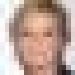

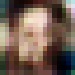

epoch =  123
Epoch [122/200], Step [28/28], d_loss: -5.9050, g_loss: -5.9608, D(x): 12.31, D(G(z)): 6.08


Epoch: 125: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-6.12, G_loss=-3.8, fake_score=3.74, real_score=10.7]


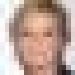

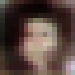

epoch =  125
Epoch [124/200], Step [28/28], d_loss: -6.1221, g_loss: -3.8010, D(x): 10.73, D(G(z)): 3.74


Epoch: 127: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.66, G_loss=-1.06, fake_score=0.744, real_score=8.98]


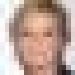

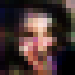

epoch =  127
Epoch [126/200], Step [28/28], d_loss: -7.6561, g_loss: -1.0595, D(x): 8.98, D(G(z)): 0.74


Epoch: 129: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.28, G_loss=-.337, fake_score=0.674, real_score=8.17]


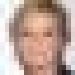

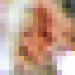

epoch =  129
Epoch [128/200], Step [28/28], d_loss: -7.2776, g_loss: -0.3372, D(x): 8.17, D(G(z)): 0.67


Epoch: 131: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-7.74, G_loss=-2.29, fake_score=2.7, real_score=10.9]


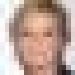

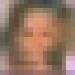

epoch =  131
Epoch [130/200], Step [28/28], d_loss: -7.7355, g_loss: -2.2938, D(x): 10.87, D(G(z)): 2.70


Epoch: 133: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-6.87, G_loss=-2.96, fake_score=3.26, real_score=10.9]


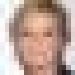

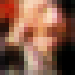

epoch =  133
Epoch [132/200], Step [28/28], d_loss: -6.8697, g_loss: -2.9563, D(x): 10.88, D(G(z)): 3.26


Epoch: 135: 100%|██████████| 28/28 [00:15<00:00,  1.84it/s, D_total_loss=-7.17, G_loss=-3.07, fake_score=3.29, real_score=10.9]


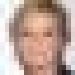

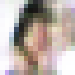

epoch =  135
Epoch [134/200], Step [28/28], d_loss: -7.1697, g_loss: -3.0734, D(x): 10.89, D(G(z)): 3.29


Epoch: 137: 100%|██████████| 28/28 [00:15<00:00,  1.84it/s, D_total_loss=-7.28, G_loss=-2.26, fake_score=2.17, real_score=10.6]


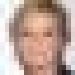

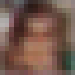

epoch =  137
Epoch [136/200], Step [28/28], d_loss: -7.2800, g_loss: -2.2599, D(x): 10.55, D(G(z)): 2.17


Epoch: 139: 100%|██████████| 28/28 [00:15<00:00,  1.84it/s, D_total_loss=-6.21, G_loss=-3.03, fake_score=3.03, real_score=11]


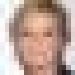

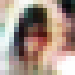

epoch =  139
Epoch [138/200], Step [28/28], d_loss: -6.2142, g_loss: -3.0324, D(x): 11.05, D(G(z)): 3.03


Epoch: 141: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-6.92, G_loss=-3.23, fake_score=3.4, real_score=10.9]


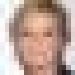

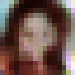

epoch =  141
Epoch [140/200], Step [28/28], d_loss: -6.9237, g_loss: -3.2292, D(x): 10.95, D(G(z)): 3.40


Epoch: 143: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.86, G_loss=-1.27, fake_score=1.58, real_score=10]


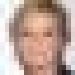

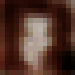

epoch =  143
Epoch [142/200], Step [28/28], d_loss: -7.8574, g_loss: -1.2675, D(x): 10.03, D(G(z)): 1.58


Epoch: 145: 100%|██████████| 28/28 [00:15<00:00,  1.84it/s, D_total_loss=-7.84, G_loss=-2.54, fake_score=2.73, real_score=10.8]


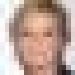

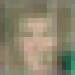

epoch =  145
Epoch [144/200], Step [28/28], d_loss: -7.8429, g_loss: -2.5365, D(x): 10.77, D(G(z)): 2.73


Epoch: 147: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.45, G_loss=-5.01, fake_score=4.93, real_score=13]


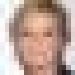

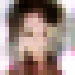

epoch =  147
Epoch [146/200], Step [28/28], d_loss: -7.4476, g_loss: -5.0145, D(x): 12.95, D(G(z)): 4.93


Epoch: 149: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.17, G_loss=-4.74, fake_score=4.53, real_score=12]


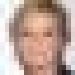

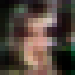

epoch =  149
Epoch [148/200], Step [28/28], d_loss: -7.1720, g_loss: -4.7435, D(x): 12.02, D(G(z)): 4.53


Epoch: 151: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-7.6, G_loss=-1.91, fake_score=1.9, real_score=9.74]


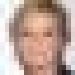

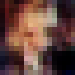

epoch =  151
Epoch [150/200], Step [28/28], d_loss: -7.5998, g_loss: -1.9078, D(x): 9.74, D(G(z)): 1.90


Epoch: 153: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.67, G_loss=-.802, fake_score=1.03, real_score=9.24]


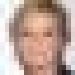

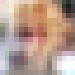

epoch =  153
Epoch [152/200], Step [28/28], d_loss: -7.6671, g_loss: -0.8016, D(x): 9.24, D(G(z)): 1.03


Epoch: 155: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-6.45, G_loss=-3.36, fake_score=3.76, real_score=10.7]


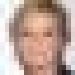

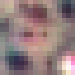

epoch =  155
Epoch [154/200], Step [28/28], d_loss: -6.4517, g_loss: -3.3564, D(x): 10.68, D(G(z)): 3.76


Epoch: 157: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.85, G_loss=-4.57, fake_score=4.57, real_score=13.8]


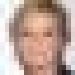

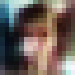

epoch =  157
Epoch [156/200], Step [28/28], d_loss: -7.8508, g_loss: -4.5684, D(x): 13.76, D(G(z)): 4.57


Epoch: 159: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-6.99, G_loss=-3.85, fake_score=3.84, real_score=11]


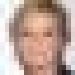

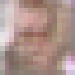

epoch =  159
Epoch [158/200], Step [28/28], d_loss: -6.9876, g_loss: -3.8506, D(x): 10.99, D(G(z)): 3.84


Epoch: 161: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-7.49, G_loss=-1.32, fake_score=1.51, real_score=9.24]


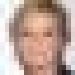

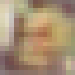

epoch =  161
Epoch [160/200], Step [28/28], d_loss: -7.4906, g_loss: -1.3185, D(x): 9.24, D(G(z)): 1.51


Epoch: 163: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-8.61, G_loss=-.0808, fake_score=-.329, real_score=8.82]


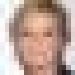

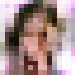

epoch =  163
Epoch [162/200], Step [28/28], d_loss: -8.6077, g_loss: -0.0808, D(x): 8.82, D(G(z)): -0.33


Epoch: 165: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-6.79, G_loss=-1.77, fake_score=2.53, real_score=9.57]


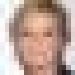

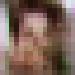

epoch =  165
Epoch [164/200], Step [28/28], d_loss: -6.7878, g_loss: -1.7690, D(x): 9.57, D(G(z)): 2.53


Epoch: 167: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-8.13, G_loss=-4.77, fake_score=5.1, real_score=13.9]


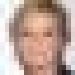

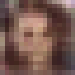

epoch =  167
Epoch [166/200], Step [28/28], d_loss: -8.1282, g_loss: -4.7685, D(x): 13.88, D(G(z)): 5.10


Epoch: 169: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-6.98, G_loss=-4.25, fake_score=3.99, real_score=12.3]


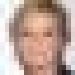

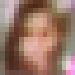

epoch =  169
Epoch [168/200], Step [28/28], d_loss: -6.9794, g_loss: -4.2529, D(x): 12.26, D(G(z)): 3.99


Epoch: 171: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-8.1, G_loss=-3.13, fake_score=3.07, real_score=11.4]


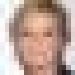

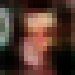

epoch =  171
Epoch [170/200], Step [28/28], d_loss: -8.1002, g_loss: -3.1292, D(x): 11.44, D(G(z)): 3.07


Epoch: 173: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.46, G_loss=-3.16, fake_score=3.18, real_score=11]


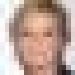

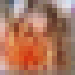

epoch =  173
Epoch [172/200], Step [28/28], d_loss: -7.4551, g_loss: -3.1560, D(x): 10.95, D(G(z)): 3.18


Epoch: 175: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.2, G_loss=-3.4, fake_score=3.6, real_score=11.8]


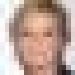

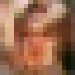

epoch =  175
Epoch [174/200], Step [28/28], d_loss: -7.1994, g_loss: -3.4026, D(x): 11.76, D(G(z)): 3.60


Epoch: 177: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.22, G_loss=-2.32, fake_score=2.49, real_score=10.2]


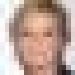

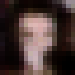

epoch =  177
Epoch [176/200], Step [28/28], d_loss: -7.2173, g_loss: -2.3175, D(x): 10.18, D(G(z)): 2.49


Epoch: 179: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.8, G_loss=-1.43, fake_score=1.33, real_score=9.28]


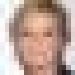

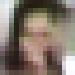

epoch =  179
Epoch [178/200], Step [28/28], d_loss: -7.7969, g_loss: -1.4313, D(x): 9.28, D(G(z)): 1.33


Epoch: 181: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.12, G_loss=-2.24, fake_score=2.47, real_score=9.87]


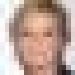

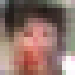

epoch =  181
Epoch [180/200], Step [28/28], d_loss: -7.1211, g_loss: -2.2395, D(x): 9.87, D(G(z)): 2.47


Epoch: 183: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-7.67, G_loss=-2.7, fake_score=3.02, real_score=11.1]


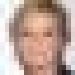

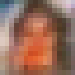

epoch =  183
Epoch [182/200], Step [28/28], d_loss: -7.6748, g_loss: -2.7017, D(x): 11.07, D(G(z)): 3.02


Epoch: 185: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-7.15, G_loss=-2.91, fake_score=2.84, real_score=11]


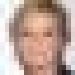

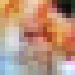

epoch =  185
Epoch [184/200], Step [28/28], d_loss: -7.1535, g_loss: -2.9055, D(x): 11.01, D(G(z)): 2.84


Epoch: 187: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-6.83, G_loss=-2.72, fake_score=2.88, real_score=10.2]


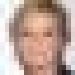

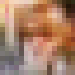

epoch =  187
Epoch [186/200], Step [28/28], d_loss: -6.8308, g_loss: -2.7249, D(x): 10.19, D(G(z)): 2.88


Epoch: 189: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-7.2, G_loss=-1.93, fake_score=1.79, real_score=9.27]


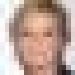

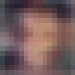

epoch =  189
Epoch [188/200], Step [28/28], d_loss: -7.1957, g_loss: -1.9301, D(x): 9.27, D(G(z)): 1.79


Epoch: 191: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s, D_total_loss=-7.51, G_loss=-2.09, fake_score=2.08, real_score=9.78]


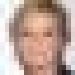

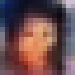

epoch =  191
Epoch [190/200], Step [28/28], d_loss: -7.5076, g_loss: -2.0912, D(x): 9.78, D(G(z)): 2.08


Epoch: 193: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-7.6, G_loss=-3.1, fake_score=2.72, real_score=10.7]


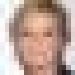

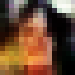

epoch =  193
Epoch [192/200], Step [28/28], d_loss: -7.6047, g_loss: -3.1042, D(x): 10.75, D(G(z)): 2.72


Epoch: 195: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s, D_total_loss=-7.56, G_loss=-2.23, fake_score=2.21, real_score=9.98]


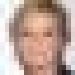

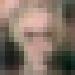

epoch =  195
Epoch [194/200], Step [28/28], d_loss: -7.5594, g_loss: -2.2341, D(x): 9.98, D(G(z)): 2.21


Epoch: 197: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s, D_total_loss=-7.29, G_loss=-2.34, fake_score=2.38, real_score=9.87]


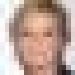

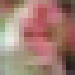

epoch =  197
Epoch [196/200], Step [28/28], d_loss: -7.2905, g_loss: -2.3400, D(x): 9.87, D(G(z)): 2.38


Epoch: 199: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s, D_total_loss=-5.13, G_loss=-2.06, fake_score=2.49, real_score=10.2]


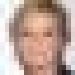

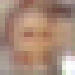

epoch =  199
Epoch [198/200], Step [28/28], d_loss: -5.1269, g_loss: -2.0598, D(x): 10.25, D(G(z)): 2.49


Epoch: 200: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s, D_total_loss=-7.08, G_loss=-3.01, fake_score=3.33, real_score=10.6]


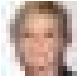

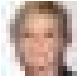

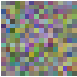

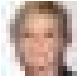

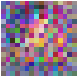

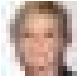

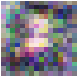

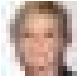

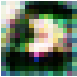

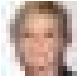

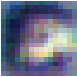

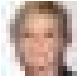

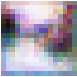

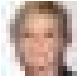

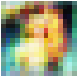

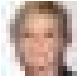

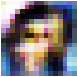

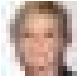

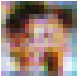

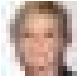

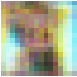

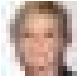

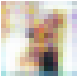

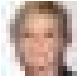

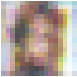

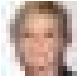

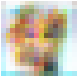

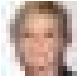

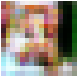

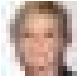

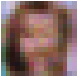

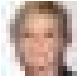

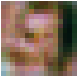

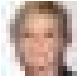

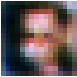

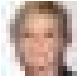

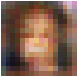

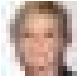

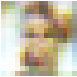

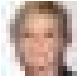

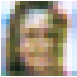

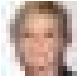

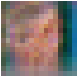

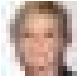

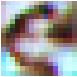

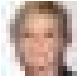

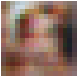

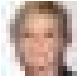

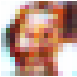

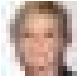

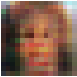

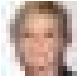

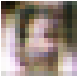

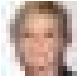

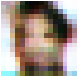

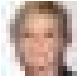

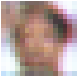

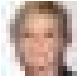

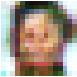

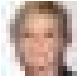

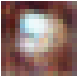

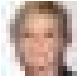

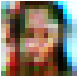

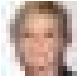

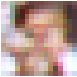

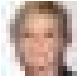

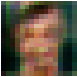

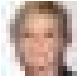

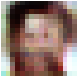

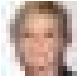

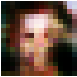

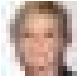

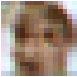

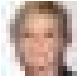

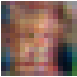

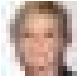

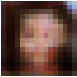

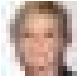

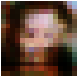

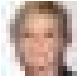

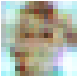

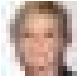

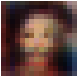

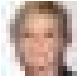

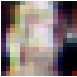

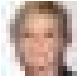

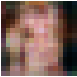

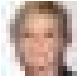

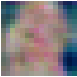

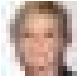

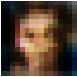

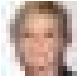

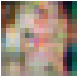

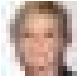

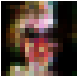

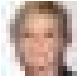

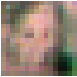

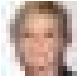

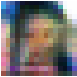

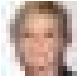

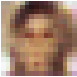

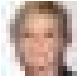

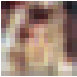

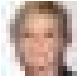

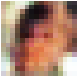

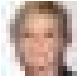

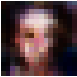

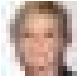

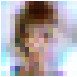

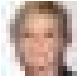

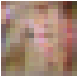

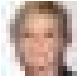

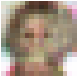

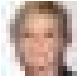

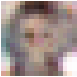

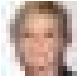

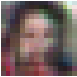

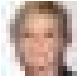

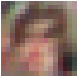

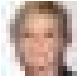

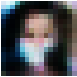

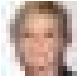

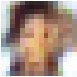

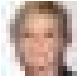

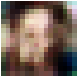

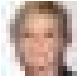

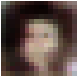

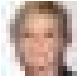

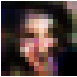

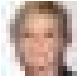

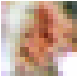

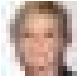

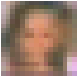

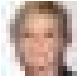

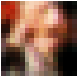

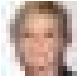

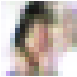

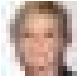

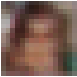

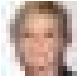

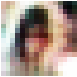

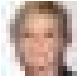

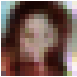

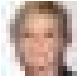

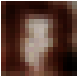

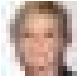

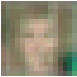

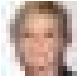

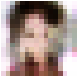

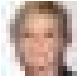

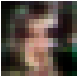

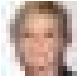

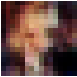

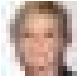

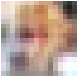

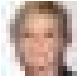

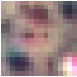

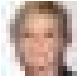

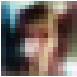

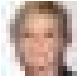

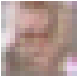

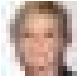

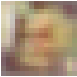

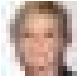

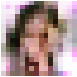

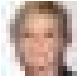

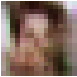

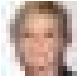

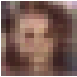

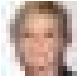

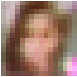

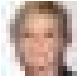

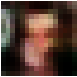

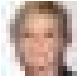

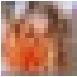

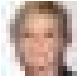

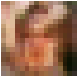

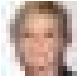

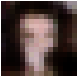

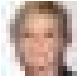

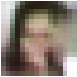

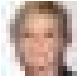

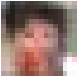

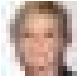

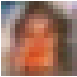

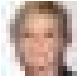

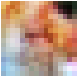

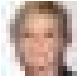

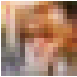

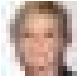

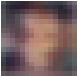

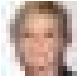

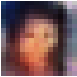

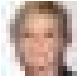

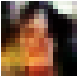

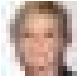

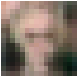

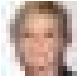

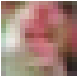

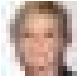

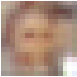

In [72]:
for i in range(iteration):

    p = tqdm(range(total_data_len // batch_size + 1)) # This is a progress bar run on each epoch
    
    datasets_batched = DataLoader(dataset, batch_size = batch_size)
    
    loader = iter(datasets_batched)

    # real_score = t.Tensor(2)

    # fake_score = t.Tensor(2)

    # g_fake_loss = t.Tensor([2])


    for j in p:
        

        batchNum = str(i+1)
        
        #Training the D
        #real data
        real = next(loader).to(device)

        #current_batch size (the last batch is different than others)
        current_batch_size, c, h, w = real.shape
        #labels
        label_real = 0.1 * t.randint(7,10,(current_batch_size,1)).type(t.half)
        label_fake = 0.1 * t.randint(0,3,(current_batch_size,1)).type(t.half)

        real_score = discriminator(real)
        d_real_loss = -t.mean(real_score)
        
        input_noise = t.normal(0, 1, size = (current_batch_size, 1, 1, laten_space)).to(device)
        fake = generator(input_noise, current_batch_size)
        fake_score = discriminator(fake)

        d_fake_loss = t.mean(fake_score)

        gradient_penalty = compute_gradient_penalty(discriminator, real, fake, current_batch_size)
        
        total_loss = d_fake_loss + d_real_loss + gradient_penalty

        discriminator.zero_grad()
        generator.zero_grad()
        total_loss.backward()
        D_optimizer.step()
        

        
        #Training the G
        
        if j % critic == 0:
          input_noise = t.normal(0, 1, size = (current_batch_size, 1, 1, laten_space)).to(device)
          fake = generator(input_noise, current_batch_size)
          fake_score = discriminator(fake)

          g_fake_loss = -t.mean(fake_score)

          discriminator.zero_grad()
          generator.zero_grad()
          g_fake_loss.backward()
          G_optimizer.step()
        

        
        mse = "Epoch: " + batchNum
        
        p.set_description(mse)
            
        p.set_postfix(G_loss = g_fake_loss.item(), D_total_loss = total_loss.item(), real_score = real_score.mean().item(), fake_score = fake_score.mean().item())
        
    if i == 0:
        showOneImge(real[0], 99999, True)   
    
    if i % 2 == 0:
      
      showOneImge(real[0], 99999, False)
      showOneImge(fake[0], i, False)
      print("epoch = ", i + 1)  
      print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(i, iteration, j+1, total_data_len // batch_size + 1, total_loss.item(), g_fake_loss.item(), real_score.mean().item(), fake_score.mean().item()))      
      

    if i % 50 == 0:
      t.save(generator.state_dict(), f'{log_folder}/checkpoint/{str(i + 1).zfill(6)}_g.model')
      t.save(discriminator.state_dict(), f'{log_folder}/checkpoint/{str(i + 1).zfill(6)}_d.model')


### Evaluating the Generator

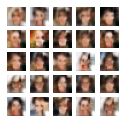

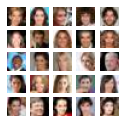

In [73]:


generator.eval()

with t.no_grad():
  input_noise = t.normal(0, 1, size = (eval_size, 1, 1, laten_space)).to(device)
  fake = generator(input_noise, eval_size).cpu()
  
  showMoreImages(fake, eval_size)

datasets_batched = DataLoader(dataset, batch_size = eval_size)
  
loader = iter(datasets_batched)
real = next(loader)

showMoreImages(real, eval_size)





### remove log file when necessarry

In [74]:
# !rm -rf /content/log/checkpoint

# !mkdir /content/log/checkpoint

# !rm -rf /content/log/sample
# !mkdir /content/log/sample

# from google.colab import files
# files.download('/content/log') 